In [2]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [3]:
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import os
from scipy.misc import imread ,imresize
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import feature, io, morphology, measure, img_as_uint, filters
from skimage.transform import rescale, resize
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, k_means
from sklearn.decomposition import PCA, FastICA, KernelPCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
import cv2 
import mahotas#for obtaining color histogram
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#IMPORTING MODELS
from sklearn_extensions.extreme_learning_machines.elm import ELMClassifier,GenELMClassifier,MLPRandomLayer
import xgboost 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.layers import Dense,Dropout,BatchNormalization,Activation,merge,Input,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import nadam
from sklearn.decomposition import PCA

/home/yash/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yash/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


In [4]:
train_root='/home/yash/Desktop/train_whole_plant/train'
validation_root='/home/yash/Desktop/train_whole_plant/test'

In [5]:
text=open(os.path.join(train_root,'train.txt'))    
lines=text.read()  
train_images=[]
for i in range(1,2289):
    image_name=lines.split('\\')[i].split('\nClass')[0]
    train_images.append(image_name)
train_images[2287]='R_90Class44 (8).jpg'

In [6]:
text=open(os.path.join(train_root,'val.txt'))    
lines=text.read()  
test_images=[]
for i in range(1,529):
    image_name=lines.split('\\')[i].split('\nClass')[0]
    test_images.append(image_name)
test_images[527]='R_45Class44 (3).jpg'    

In [51]:
# train_array=[]
# for i in range(1,45): 
#     image_class=os.path.join(train_root,str('Class ('+str(i)+')'))
#     for image in train_images[(i-1)*52:(i-1)*52+52]:
#         img_path=os.path.join(image_class,image)
#         img=cv2.imread(img_path)
#         #img=imresize(img,(256,256))
#         #tupl=(i,img)
#         train_array.append(img)  
train_array=np.array(train_array)   
train_dl=train_array/255

In [53]:
test_array=[]
for i in range(1,45): 
    image_class=os.path.join(validation_root,str('Class ('+str(i)+')'))
    for image in test_images[(i-1)*12:(i-1)*12+12]:
        img_path=os.path.join(image_class,image)
        img=cv2.imread(img_path)
        #img=imresize(img,(256,256))
        #tupl=(i,img)
        test_array.append(img)
test_array=np.array(test_array)   
test_dl=test_array/255

In [8]:
y_train=[]
for i in range(1,45):
    for j in range(52):
        y_train.append(i)
y_train=np.array(y_train)
y_test=[]
for i in range(1,45):
    for j in range(12):
        y_test.append(i)
y_train_label=y_train
y_test_label=y_test
y_train=pd.get_dummies(y_train,prefix='class')
y_test=pd.get_dummies(y_test,prefix='class') 

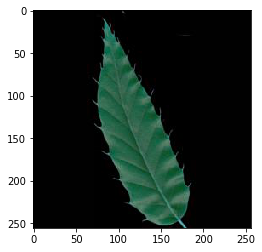

In [9]:
plt.imshow(train_array[1])
plt.show()

In [12]:
train_gray=[]
train_binary_image=[]
for i in range(0,len(train_array)):
        gray=cv2.cvtColor(train_array[i],cv2.COLOR_BGR2GRAY)
        train_gray.append(gray)
for i in range(0,len(train_gray)):
    (thresh, im_bw) = cv2.threshold(train_gray[i], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    train_binary_image.append(im_bw)

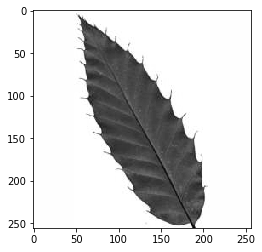

In [13]:
plt.imshow(train_gray[3],cmap='gray_r')
plt.show()

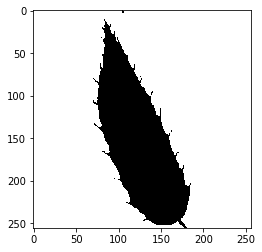

In [14]:
plt.imshow(train_binary_image[1],cmap='gray_r')

# Hu moments , Haralick and Color Histograms

In [15]:
def feature_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
# feature-descriptor-2: Haralick Texture
def feature_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick
bins=8
def feature_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [16]:
def extract_features(data):
    extracted=[]
    hu_features=[]
    har_features=[]
    hist_features=[]
    for i in range(data.shape[0]):
        hu=feature_hu_moments(data[i])
        har=feature_haralick(data[i])
        hist=feature_histogram(data[i])
        hu_features.append(hu)
        har_features.append(har)
        hist_features.append(hist)
        extracted_feature=np.hstack([hu,har,hist])
        extracted.append(extracted_feature)  
    return hu_features,har_features,hist_features,extracted    

In [17]:
hu_train,har_train,hist_train,feature_vector=extract_features(train_array)
hu_test,har_test,hist_test,test_feature_vector=extract_features(test_array)
# for i in [hu_train,har_train,hist_train,feature_vector,hu_test,har_test,hist_test,test_feature_vector]:
#     i =np.array(i)

In [18]:
df=pd.DataFrame(feature_vector)
test_df=pd.DataFrame(test_feature_vector)
min_max=MinMaxScaler(feature_range=(0,1))
rescaled=min_max.fit_transform(df)
rescaled_test=min_max.transform(test_df)

In [166]:
xgb=xgb.XGBClassifier(n_estimators=200)
cross_val_score(xgb,rescaled,y_train_label,cv=10,scoring='accuracy').mean()

0.94545454545454555

In [227]:
xgb=xgboost.XGBClassifier(n_estimators=200)
xgb.fit(rescaled,y_train_label)
xgb_pred=xgb.predict(rescaled_test)
accuracy_score(y_test_label,xgb_pred)

0.95833333333333337

In [229]:
xgb_1=xgboost.XGBClassifier(n_estimators=300)
xgb_1.fit(rescaled,y_train_label)
xgb_pred_1=xgb_1.predict(rescaled_test)
accuracy_score(y_test_label,xgb_pred_1)

0.96022727272727271

# ELM-Extreme Learning Machine

In [19]:
from hpelm import ELM

In [20]:
from hpelm import ELM
elm=ELM(rescaled.shape[1],y_train.shape[1],norm=0.035)
elm.add_neurons(number=1000,func='tanh')
elm.train(rescaled,y_train.values)
elm_pred=elm.predict(rescaled_test)
elm_pred_1=np.argmax(elm_pred,axis=1)+1
accuracy_score(y_test_label,elm_pred_1)

0.89393939393939392

In [21]:
np.sum(elm_pred[78])

0.99996838854280523

In [22]:
#lets decompose
def decompose_into(n,model):
    pca=PCA(n_components=n)
    rescaled_decompose=pca.fit_transform(rescaled)
    rescaled_decompose_test=pca.transform(rescaled_test)
    if model=='elm':
        elm_with_pca=ELM(rescaled_decompose.shape[1],y_train.shape[1],norm=0.035)
        elm_with_pca.add_neurons(number=1100,func='tanh')
        elm_with_pca.train(rescaled_decompose,y_train.values)
        elm_with_pca_pred=elm_with_pca.predict(rescaled_decompose_test)
        elm_pred_pca=np.argmax(elm_with_pca_pred,axis=1)+1
        acc=accuracy_score(y_test_label,elm_pred_pca)
        i=220+(n/100-1)
#         plt.subplot(i)
#         plt.plot(range(1,n+1),pca.explained_variance_ratio_)
#         plt.xlabel('Number of Components')
#         plt.ylabel('Explained _ratio')
        return acc
    elif model=='xgb':
        xg_pca=xgboost.XGBClassifier(n_estimators=250)
        xg_pca.fit(rescaled_decompose,y_train_label)
        xg_pca_pred=xg_pca.predict(rescaled_decompose_test)
        acc_xg=accuracy_score(xg_pca_pred,y_test_label)
        return acc_xg

In [23]:
#for ELM
start=time.time()
for i in [15,20,25,30,35,532]:
    accuracy_elm=decompose_into(i,'elm')
    print ('Accuracy when there are {0} principal_components :{1}'.format(i,accuracy_elm))
end=time.time()
print (end-start)

Accuracy when there are 15 principal_components :0.9242424242424242
Accuracy when there are 20 principal_components :0.9128787878787878
Accuracy when there are 25 principal_components :0.9128787878787878
Accuracy when there are 30 principal_components :0.9147727272727273
Accuracy when there are 35 principal_components :0.884469696969697
Accuracy when there are 532 principal_components :0.8768939393939394
2.872556209564209


In [424]:
# #for xgboost
# start=time.time()
# for i in [15,20,25,30,35]:
#     accuracy=decompose_into(i,'xgb')
#     print ('Accuracy when there are {0} principal_components :{1}'.format(i,accuracy))
# end=time.time()
# print (end-start)

In [467]:
# for i,j in zip([hu_train,har_train,hist_train],[hu_test,har_test,hist_test]):
#     elm_new=ELM(i[0].shape[0],y_train.shape[0],norm=.0)
#     elm_new.add_neurons(number=1000,func='tanh')
#     predictions=elm_new.predict(j)
#     pred_label=np.argmax(predictions,axis=1)+1
#     new_acc=accuracy_score(pred_label,y_test_label)
#     print ('Accuracy with {0} is :{1}'.format(i,new_acc))
    